In [2]:
import ray

ray.shutdown()
ray.init(ignore_reinit_error=True, num_gpus=1, _metrics_export_port=8080, include_dashboard=True,
         configure_logging=False)

Python version:,3.9.13
Ray version:,2.9.1
Dashboard:,http://127.0.0.1:8265


In [4]:
from minigrid.wrappers import FlatObsWrapper


class CustomFlatObsWrapper(FlatObsWrapper):
    def __init__(self, env):
        super().__init__(env)

In [5]:
from gymnasium.envs.registration import register

try:
    import gymnasium as gym

    gymnasium = True
except Exception:
    import gym

    gymnasium = False

ENV_ID = "MiniGrid-CustomMultiRoom-N6-v0"

# Register the custom environment
register(
    id=ENV_ID,
    entry_point='custom_env:CustomMultiRoomEnv',
    max_episode_steps=1000,
)


In [6]:
from custom_env import CustomMultiRoomEnv

try:
    import gymnasium as gym

    gymnasium = True
except Exception:
    import gym

    gymnasium = False
from ray.tune import register_env


def env_creator(env_config=None):
    # if env_config is None:
    #     env_config = {
    #         'agent_start_pos': (1, 1),
    #         'agent_start_dir': 0,
    #         'goal_pos': (7, 7),
    #         'minNumRooms': 2,
    #         'maxNumRooms': 5
    #     }
    env = CustomMultiRoomEnv(agent_start_pos=(1, 1),
                             agent_start_dir=0,
                             goal_pos=(7, 7),
                             minNumRooms=2,
                             maxNumRooms=5, **env_config)
    env.reset()
    env = CustomFlatObsWrapper(env)
    return env


# Register the custom environment
register_env("my_minigrid_env", env_creator)


In [7]:
from ray.rllib.algorithms.callbacks import DefaultCallbacks
from ray.rllib import BaseEnv, Policy
from typing import Dict, Union, Optional
from ray.rllib import BaseEnv, Policy
from ray.rllib.evaluation import Episode
from ray.rllib.evaluation.episode_v2 import EpisodeV2
from ray.rllib.utils.typing import PolicyID


class AccuracyCallback(DefaultCallbacks):
    def on_episode_end(
            self,
            *,
            worker: "RolloutWorker",
            base_env: BaseEnv,
            policies: Dict[PolicyID, Policy],
            episode: Union[Episode, EpisodeV2, Exception],
            env_index: Optional[int] = None,
            **kwargs,
    ) -> None:
        super(DefaultCallbacks, self).on_episode_end(worker=worker, base_env=base_env,
                                                     policies=policies, episode=episode,
                                                     env_index=env_index, **kwargs)

        episode.custom_metrics["mean_accuracy"] = 0

In [8]:
from ray.rllib.algorithms.dqn import DQNConfig
from ray.air import RunConfig
from ray import train

tune_config = DQNConfig().environment("my_minigrid_env").rollouts(
    num_envs_per_worker=20,
    observation_filter="MeanStdFilter",
    num_rollout_workers=0,
).exploration(
    explore=True,
    exploration_config={
        "type": "EpsilonGreedy",
        "initial_epsilon": 1.0,
        "final_epsilon": 0.1,
        "epsilon_timesteps": 10000,
    }
).training()

tune_config_dict = tune_config.to_dict()
# Example stop criteria for MiniGrid-MultiRoom-N6-v0
stop = {
    "training_iteration": 10000,  # Increase the number of training iterations to give the agent more time to learn
    "timesteps_total": 5000000,  # Increase the total number of steps to allow the agent to gather more experience
    "episode_reward_mean": 0.95,
    # Uncomment and set a target average reward per episode if you have a specific performance level in mind
    # "time_total_s": 36000,  # Uncomment and set a maximum training time in seconds if you have a time constraint
}
# Setup your RunConfig
run_config = RunConfig(
    name="new_experiment",
    stop=stop,
    storage_path="C:\\Users\\BerkayEren\\PycharmProjects\\rl-learning\\ray_results",
    checkpoint_config=train.CheckpointConfig(
        checkpoint_score_attribute="mean_accuracy",
        num_to_keep=5,
    ),
)

In [9]:
from ray import tune
from ray.tune.schedulers import ASHAScheduler

from ray.tune import register_env

# Register the custom environment
register_env("my_minigrid_env", env_creator)

tuner = tune.Tuner(
    "DQN",
    param_space={
        "lr": tune.loguniform(0.001, 0.1),
        "momentum": tune.grid_search([0.8, 0.9, 0.99]),
        "should_checkpoint": True,
        "callbacks": AccuracyCallback,
        **tune_config
    },
    run_config=train.RunConfig(
        name="new_experiment",
        stop=stop,
        checkpoint_config=train.CheckpointConfig(
            num_to_keep=5,
            checkpoint_at_end=True,
            checkpoint_frequency=50
        ),
        storage_path="C:\\Users\\BerkayEren\\PycharmProjects\\rl-learning\\ray_results",
    ),
    tune_config=tune.TuneConfig(mode="max", metric="episode_reward_mean", num_samples=2, scheduler=ASHAScheduler(), ),

)
# Start the tuning process
result = tuner.fit()


In [11]:
import numpy as np
from ray.rllib.algorithms import DQN

best_result = result.get_best_result()
best_checkpoint = best_result.get_best_checkpoint('episode_reward_mean', 'max')

trainer = DQN(config=tune_config_dict)
# You can now restore your trainer from this checkpoint as shown previously
trainer.restore(best_checkpoint)

# Initialize a list to store the observations from each trial
all_observations = []

# Run the environment loop 4 times
for trial in range(4):
    env = env_creator({"render_mode": "human"})
    observation, info = env.reset()
    done = False
    action = None
    reward = 0

    visited_states = {}
    while not done:
        # Compute the action using the trained policy
        action = trainer.compute_single_action(observation=observation, prev_action=action, prev_reward=reward)

        # Take the action in the environment
        observation, reward, done, info, _ = env.step(action)
        
        visited_states.setdefault(env.agent_pos, 0)
        visited_states[env.agent_pos] += 1

        # Render the environment
        env.render()

    all_observations.append(visited_states)


C:\Users\BerkayEren\PycharmProjects\rl-learning\worker_env\lib\site-packages\ray\rllib\algorithms\algorithm.py:483: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
C:\Users\BerkayEren\PycharmProjects\rl-learning\worker_env\lib\site-packages\ray\tune\logger\unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of the `ray.tune.json.JsonLoggerCallback` interface and will be removed in Ray 2.7.
  self._loggers.append(cls(self.config, self.logdir, self.trial))
C:\Users\BerkayEren\PycharmProjects\rl-learning\worker_env\lib\site-packages\ray\tune\logger\unified.p

TypeError: Image data of dtype object cannot be converted to float

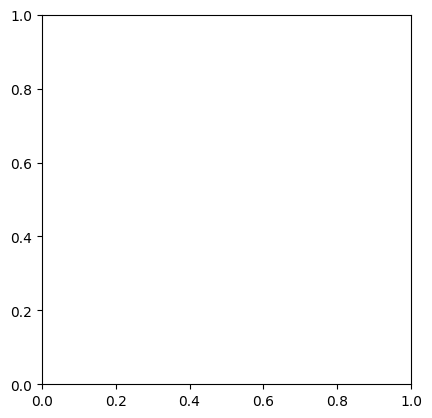

In [17]:
import matplotlib.pyplot as plt
# Generate and save a heatmap for each trial
for i, trial_observations in enumerate(all_observations):
    # Convert the list of observations to a numpy array
    # trial_observations = np.array(trial_observations)
    visited_states = np.nan_to_num(trial_observations)

    # Generate the heatmap
    plt.imshow(visited_states, cmap='hot', interpolation='nearest')
    plt.colorbar()
    plt.title(f'Heatmap of Visited States in Trial {i + 1}')

    # Save the heatmap to a file
    plt.savefig(f'heatmap_trial_{i + 1}.png')

    # Clear the current figure so the next heatmap doesn't overlap with this one
    plt.clf()